# XGBoost

### Setup

In [4]:
#imports
# load needed libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json


# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, precision_score, recall_score
# Added this to simulate bootstrapped sampeles in the "Manual" Random Forest
from sklearn.utils import resample

# sklearn models
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import random

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS3540/Final Project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['LogisticRegression.ipynb', 'fakeAccountData.json', 'realAccountData.json', 'RandomForest.ipynb', 'XGBoost.ipynb']


In [5]:
#setting a random seed for reproducibility
random.seed(4)

In [6]:
#getting the data
realData = pd.read_json(GOOGLE_DRIVE_PATH + 'realAccountData.json')
fakeData = pd.read_json(GOOGLE_DRIVE_PATH + 'fakeAccountData.json')

allData = pd.concat([realData, fakeData], ignore_index=True)

In [ ]:
# allData[1] #making sure the combination works

In [ ]:
#making sure the data came in correctly
# fakeData[0], realData[0]
# realData[1]

In [7]:
#turning into numpy arrays
numpy_real = np.array(realData)
# print(numpy_real[1]) #making sure things work
numpy_fake = np.array(fakeData)
# print(numpy_fake[1]) #making sure things work
numpy_all = np.array(allData)
# print(numpy_all[1]) #making sure things work


# XGBoost

In [8]:
num_cols = allData.shape[1]
X = allData.iloc[:,0:num_cols-1] # iloc slicing function
Y = allData.iloc[:,num_cols-1:num_cols]
Y = np.ravel(Y)

display(allData)

,userFollowerCount,userFollowingCount,userBiographyLength,userMediaCount,userHasProfilPic,userIsPrivate,usernameDigitCount,usernameLength,isFake
0,258,238,0,0,1,0,0,10,0
1,263,482,30,29,1,1,0,8,0
2,51,78,9,0,1,1,0,10,0
3,297,480,22,25,1,1,2,9,0
4,113,242,0,95,1,1,0,10,0
...,...,...,...,...,...,...,...,...,...
1189,0,25,138,6,1,0,0,10,1
1190,0,0,52,6,1,0,3,7,1
1191,0,1,92,9,1,0,1,15,1
1192,1,0,60,5,1,0,1,13,1


In [12]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4)

In [19]:
boost_model = xgb.XGBClassifier(objective="binary:logistic")
boost_fit = boost_model.fit(x_train, y_train)
boost_score = boost_fit.score(x_test, y_test)

print(f"Model Accuracy: {boost_score:.3%}")




Model Accuracy: 96.656%


In [20]:
#function that you will use to convert confusion matrix to dataframe, useful for visulization.
def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

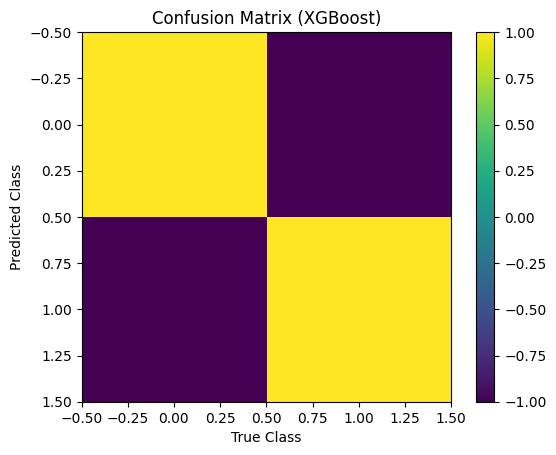

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       257
           1       0.83      0.95      0.89        42

    accuracy                           0.97       299
   macro avg       0.91      0.96      0.93       299
weighted avg       0.97      0.97      0.97       299



In [25]:
# Model Results
from sklearn.preprocessing import StandardScaler

y_test_array = np.ravel(y_test)
boost_predicted = boost_model.predict(X = x_test)

conf_matrix = confusion_matrix(y_true = y_test, y_pred = boost_predicted)
conf_matrix_scaler = StandardScaler().fit(conf_matrix)
conf_matrix_scaled = conf_matrix_scaler.transform(conf_matrix)


# the closer to 1, the more that there is
# the closer to -1 the less that there is
plt.title('Confusion Matrix (XGBoost)')
plt.imshow(conf_matrix_scaled)
plt.colorbar()
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.show()

boost_classification_report = classification_report(y_true = y_test, y_pred = boost_predicted)
print(boost_classification_report)

In [26]:
# Classification Report (Manual)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print(f"specificity: {specificity}")
recall = tp / (tp + fn)
print(f"recall: {recall}")
precision = tp / (tp + fp)
print(f"precision: {precision}")
accuracy = (tp + tn)/(tp+tn+fn+fp)
print(f"accuracy: {accuracy}")

specificity: 0.9688715953307393
recall: 0.9523809523809523
precision: 0.8333333333333334
accuracy: 0.9665551839464883


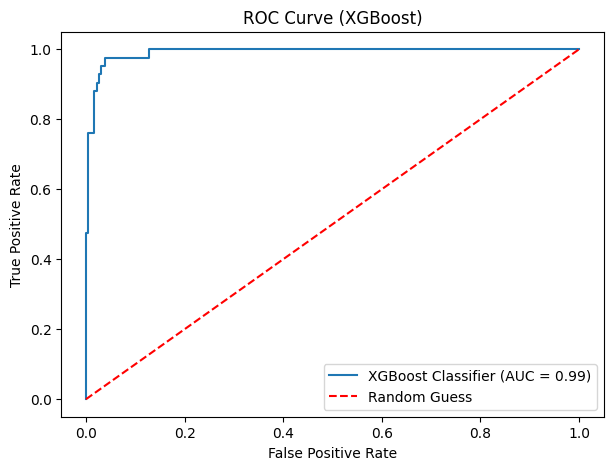

XGBoost Classifier ROC-AUC: 0.991106170094497


In [27]:
# ROC Curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# other option for how things could work
y_score = boost_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
boost_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'XGBoost Classifier (AUC = {boost_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend()
plt.show()

print(f"XGBoost Classifier ROC-AUC: {boost_roc_auc}")


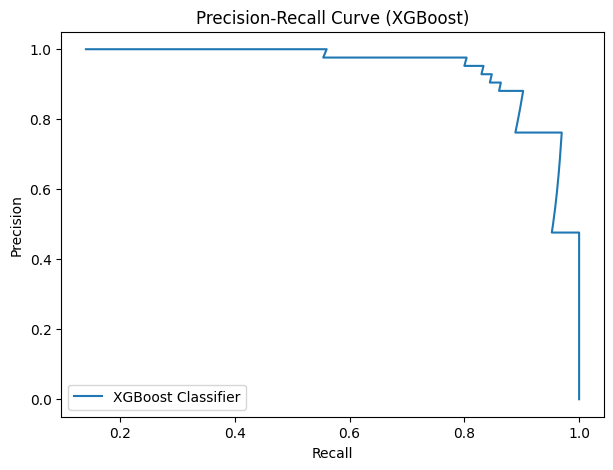

XGBoost Classifier Precision: 0.8333333333333334
XGBoost Classifier Recall: 0.9523809523809523


In [28]:
# Precision-Recall Curve
y_score = boost_model.predict_proba(x_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_score)
boost_precision_score = precision_score(y_test, boost_predicted)
boost_recall_score = recall_score(y_test, boost_predicted)

plt.figure(figsize=(7, 5))
plt.plot(precision, recall, label=f'XGBoost Classifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.show()

print(f"XGBoost Classifier Precision: {boost_precision_score}")
print(f"XGBoost Classifier Recall: {boost_recall_score}")
